# Single-Shot CNN Denoising

We demonstrate that a deep neural net can be trained to denoise a _single_ noisy image, taking advantage of the fact that one 512 x 512 image contains ~250,000 dimensions of information.

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
sys.path.append("..")
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive/codecode/noise2self'
!pip install import-ipynb
import import_ipynb

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/codecode/code/noise2self


In [ ]:
from util import show, plot_images, plot_tensors

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters import gaussian, median
from skimage import data, img_as_float, img_as_ubyte
from skimage.color import gray2rgb
from skimage.util import random_noise
from skimage.measure import compare_psnr
from skimage.measure import compare_ssim
import cv2
import math
from google.colab.patches import cv2_imshow

In [ ]:
image = img_as_float(cv2.imread('/content/gdrive/My Drive/codecode/img/train/img_401.png',0))
noisy_image = image

In [ ]:
import torch
noisy = torch.Tensor(noisy_image[np.newaxis, np.newaxis])

In [ ]:
from util import getbestgpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Masking

The strategy is to train a $J$-invariant version of a neural net by replacing a grid of pixels with the average of their neighbors, then only evaluating the model on the masked pixels.

In [ ]:
from mask import Masker
masker = Masker(width = 4, mode='interpolate')

# Model

For our model, we use a deep convolutional network.

In [ ]:
torch.manual_seed(3)
from models.dncnn import DnCNN
model = DnCNN(1, num_of_layers = 8)

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

223104

In [ ]:
image.ravel().shape

(167200,)

# Training

In [ ]:
from torch.nn import MSELoss, L1Loss
from torch.optim import Adam

loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [ ]:
model = model.to(device)
noisy = noisy.to(device)

In [ ]:
losses = []
val_losses = []
best_images = []
best_val_loss = 1

for i in range(500):
    model.train()
    
    net_input, mask = masker.mask(noisy, i % (masker.n_masks - 1))
    net_output = model(net_input)
    
    loss = loss_function(net_output*mask, noisy*mask)
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()
    
    if i % 10 == 0:
      losses.append(loss.item())
      model.eval()
      
      net_input, mask = masker.mask(noisy, masker.n_masks - 1)
      net_output = model(net_input)
  
      val_loss = loss_function(net_output*mask, noisy*mask)
      
      val_losses.append(val_loss.item())
      
      print("(", i, ") Loss: \t", round(loss.item(), 5), "\tVal Loss: \t", round(val_loss.item(), 5))

      if val_loss < best_val_loss:
        best_val_loss = val_loss
        denoised = np.clip(model(noisy).detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
        best_psnr = compare_psnr(denoised, image)
        best_images.append(denoised)
        print("\tModel PSNR: ", np.round(best_psnr, 2))
      state = model.state_dict()
      torch.save(state,"/content/gdrive/My Drive/codecode/noise2self/train_model/noise2self_model_"+str(i)+".pth")

( 0 ) Loss: 	 0.02466 	Val Loss: 	 0.28184


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


	Model PSNR:  3.91
( 10 ) Loss: 	 0.00629 	Val Loss: 	 121.76447
( 20 ) Loss: 	 0.00308 	Val Loss: 	 0.01181
	Model PSNR:  10.27
( 30 ) Loss: 	 0.00092 	Val Loss: 	 0.00123
	Model PSNR:  17.81
( 40 ) Loss: 	 0.00037 	Val Loss: 	 0.00134
( 50 ) Loss: 	 0.00025 	Val Loss: 	 0.00121
	Model PSNR:  18.84
( 60 ) Loss: 	 0.00023 	Val Loss: 	 0.00033
	Model PSNR:  22.93
( 70 ) Loss: 	 0.00017 	Val Loss: 	 0.00022
	Model PSNR:  24.75
( 80 ) Loss: 	 0.00015 	Val Loss: 	 0.00024
( 90 ) Loss: 	 0.00019 	Val Loss: 	 0.00026
( 100 ) Loss: 	 0.00014 	Val Loss: 	 0.00025
( 110 ) Loss: 	 0.00013 	Val Loss: 	 0.00026
( 120 ) Loss: 	 0.00017 	Val Loss: 	 0.00026
( 130 ) Loss: 	 0.00013 	Val Loss: 	 0.00026
( 140 ) Loss: 	 0.00011 	Val Loss: 	 0.00022
	Model PSNR:  24.81
( 150 ) Loss: 	 0.00015 	Val Loss: 	 0.00021
	Model PSNR:  24.89
( 160 ) Loss: 	 0.00011 	Val Loss: 	 0.00024
( 170 ) Loss: 	 0.0001 	Val Loss: 	 0.00016
	Model PSNR:  26.2
( 180 ) Loss: 	 0.00013 	Val Loss: 	 0.00014
	Model PSNR:  26.66


In [ ]:
state = model.state_dict()
torch.save(state,"/content/gdrive/My Drive/codecode/noise2self/train_model/noise2self_model_final.pth")

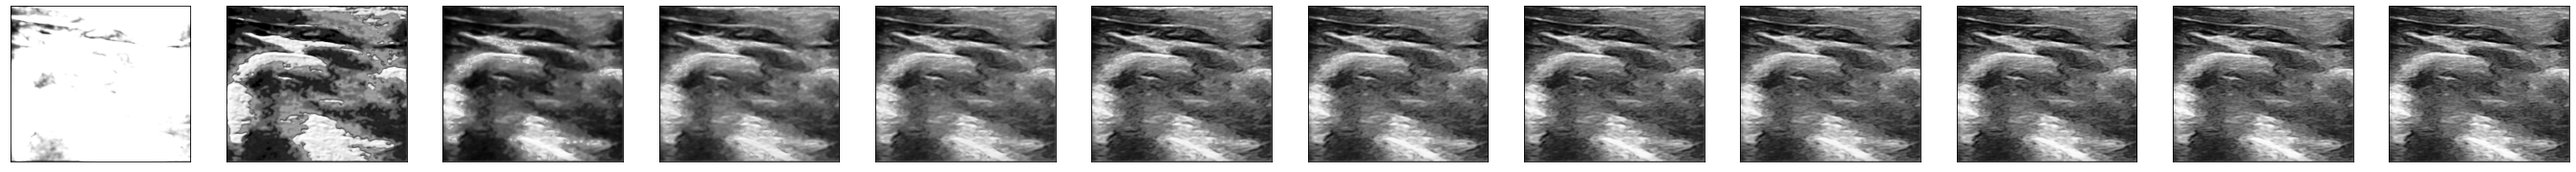

In [ ]:
plot_images(best_images[::2])

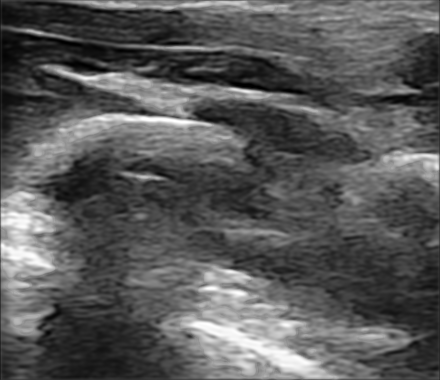

train img_401 psnr:  30.662892485190337
train img_401 ssim:  0.9286805928468191


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


In [ ]:
denoised = best_images[-1]
cv2_imshow(denoised * 255)
cv2.imwrite("/content/gdrive/My Drive/codecode/noise2self/noise2self_401.png",denoised * 255)
psnr = compare_psnr(denoised, image)
ssim = compare_ssim(denoised, image)
print('train img_401 psnr: ',psnr)
print('train img_401 ssim: ',ssim)

In [ ]:
model25 = torch.load("/content/gdrive/My Drive/codecode/noise2self/train_model/noise2self_model_final.pth")
model_test = DnCNN(1, num_of_layers = 8)
model_test.load_state_dict(model25, strict=True)
model_test.eval()
model_test = model_test.to(device)
test_img_dir = "/content/gdrive/My Drive/codecode/img/test/"
save_img_dir = "/content/gdrive/My Drive/codecode/noise2self/test_result/"
test_image_list = []
for i in range(1,55):
  test_img_name = "img_%i.png"%i
  test_image_list.append(cv2.imread(test_img_dir + test_img_name,0))

psnr_list = []
ssim_list = []
i = 1
for image in test_image_list:
  print('test img_%i'%i)
  image_1 = torch.Tensor(image[np.newaxis, np.newaxis]).to(device)
  denoised = np.squeeze(model_test(image_1).detach().cpu().numpy()).astype(np.float64)
  #print(denoised)
  cv2.imwrite(save_img_dir+'noise2self_%i.png'%i,denoised)
  psnr_img = compare_ssim(denoised, image)
  ssim_img = compare_ssim(denoised, image)
  #print('ssim: ',ssim_img)
  #print('psnr: ',psnr_img)
  psnr_list.append(psnr_img)
  ssim_list.append(ssim_img)
  i+=1
mean_psnr = np.mean(psnr_list)
mean_ssim = np.mean(ssim_list)
print(mean_ssim)
print(mean_psnr)

test img_1
test img_2
test img_3
test img_4
test img_5
test img_6
test img_7
test img_8
test img_9
test img_10
test img_11
test img_12
test img_13
test img_14
test img_15
test img_16
test img_17
test img_18
test img_19
test img_20
test img_21
test img_22
test img_23
test img_24
test img_25
test img_26
test img_27
test img_28
test img_29
test img_30
test img_31
test img_32
test img_33
test img_34
test img_35
test img_36
test img_37
test img_38
test img_39
test img_40
test img_41
test img_42
test img_43
test img_44
test img_45
test img_46
test img_47
test img_48
test img_49
test img_50
test img_51
test img_52
test img_53
test img_54
0.9085683527356458
29.483661962017724


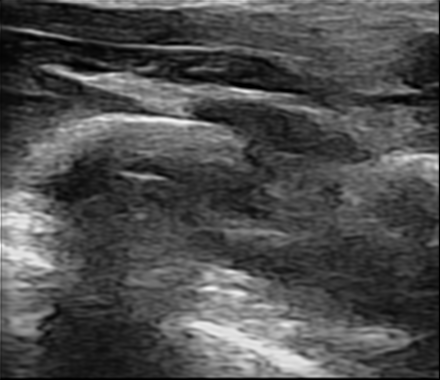

In [ ]:
show_test = cv2.imread("/content/gdrive/My Drive/codecode/noise2self/test_result/noise2self_49.png")
cv2_imshow(show_test)